In [774]:
import sys
sys.path.append('/Users/Valery/anaconda/envs/python3/lib/python3.5/site-packages')

In [775]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [776]:
import os
os.listdir("test_images/")

['extra.png',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [867]:
import math
import time
from operator import itemgetter

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny_auto_threshold(img,sigma=1):
    # median gray channel intensity
    x_center = image.shape[1]/2
    
    crop_x_l = x_center-100
    crop_x_r = x_center+100
    crop_y_t = 450+10
    crop_y_l = 450-50
    
    crop_img = img[crop_x_l:crop_x_r, crop_y_l:crop_y_t]
    
    # calculate low and high threshold
    low_threshold = max(0, crop_img.min()*sigma)
    high_threshold = min(255, crop_img.max()*sigma)   
    
    return (low_threshold, high_threshold)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    
    
    #initialization
    
    #array initialization
    rt_lane_slopes = []
    lf_lane_slopes = []
    
    #var initialization
    rt_lines_pos = []
    lf_lines_pos = []
    
    for line in lines:
        for x1,y1,x2,y2 in line: 
            
            #remove
            cv2.line(img, (x1, y1), (x2, y2), [0,0,255], thickness)
            
            pi = math.pi
            m = ((y2-y1)/(x2-x1))
            m_angle = np.arctan(m)*pi
            x_center = image.shape[1]/2
            
            #right lane
            #if m_angle > pi/16 and m_angle < pi/2:
            if m_angle > pi/4 and (x1,x2) > (x_center,x_center):
                #append slope values
                rt_lane_slopes.append(m)
                #append line positions
                rt_lines_pos.append((x1,y1))

            #elif m_angle < -pi/4 and x2 < x_center:   
            elif m_angle < -pi/4 and (x1,x2) < (x_center,x_center):   
                #append slope values
                lf_lane_slopes.append(m)
                #append line positions
                lf_lines_pos.append((x2,y2)) 
    
    #filter points to stay within standard deviation threshold
    rt_lane_slopes = np.array(rt_lane_slopes)
    lf_lane_slopes = np.array(lf_lane_slopes)
    
    rt_lane_slopes = reject_outliers(rt_lane_slopes, m=2)
    lf_lane_slopes = reject_outliers(lf_lane_slopes, m=2)
    
    #average slopes
    rt_slope_avg = np.array(rt_lane_slopes).mean()
    lf_slope_avg = np.array(lf_lane_slopes).mean()
    
    
    #----------- remove this section
    print("value of: rt_lines_pos")
    print(rt_lines_pos)
    print("value of: lf_lines_pos")
    print(lf_lines_pos)
    #-----------
    
    
    #determine right lane position
    rt_lines_pos = sorted(rt_lines_pos, key=itemgetter(0))
    rt_lane_pos = rt_lines_pos[int(math.floor(len(rt_lines_pos)/2))]
    rt_top = rt_lines_pos[0]
    
    #determine left lane position
    lf_lines_pos = sorted(lf_lines_pos, key=itemgetter(0))    
    lf_lane_pos = lf_lines_pos[int(math.floor(len(lf_lines_pos)/2))]
    lf_top = lf_lines_pos[int(len(lf_lines_pos)-1)]
    
    #set x/y position for left/right lane upper end
    rt_top_x = rt_top[0]
    rt_top_y = rt_top[1]
    
    lf_top_x = lf_top[0]
    lf_top_y = lf_top[1]
 
    rt_lw_y = image.shape[0]
    lf_lw_y = image.shape[0]

    #calculate x position for left/right lane lower end
    rt_lw_x = int(((rt_lw_y - rt_top_y) / rt_slope_avg + rt_top_x))
    lf_lw_x = int((lf_lw_y - lf_top_y) / lf_slope_avg + lf_top_x)
    
    cv2.line(img, (rt_lw_x, image.shape[0]), (rt_top_x, rt_top_y), color, thickness)
    cv2.line(img, (lf_lw_x, image.shape[0]), (lf_top_x, lf_top_y), color, thickness)  

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


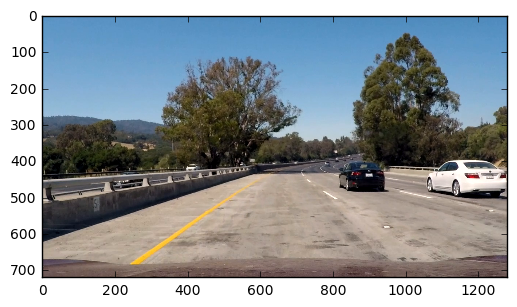

In [868]:
#reading in an image

#image = mpimg.imread('test_images/solidYellowCurve.jpg')
image = VideoFileClip('challenge.mp4').get_frame(4.5)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

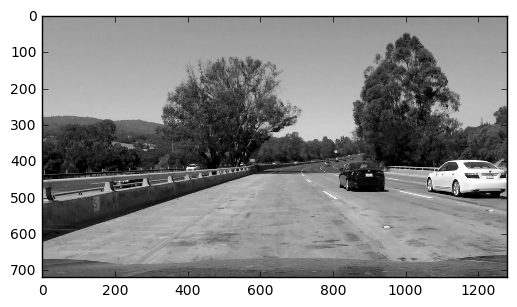

In [869]:
#reduce colored image to grayscaled image
image_grayed = grayscale(image)
plt.imshow(image_grayed, cmap='gray')

(50, 193)


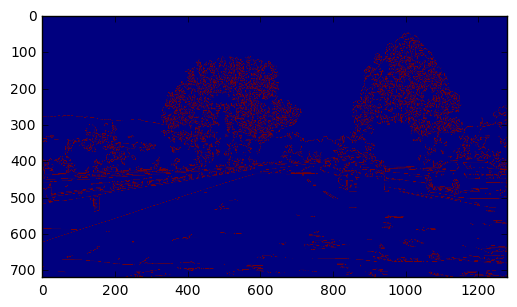

In [870]:
#apply canny to grayscaled image
canny_threshold = canny_auto_threshold(image_grayed)
image_canny = canny(image_grayed,canny_threshold[0],canny_threshold[1])
print(canny_threshold)
#image_canny = canny(image_grayed,230,255)
plt.imshow(image_canny)

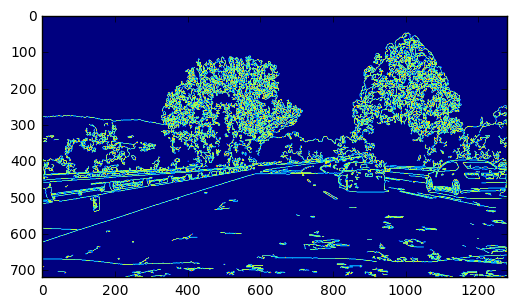

In [871]:
#apply gaussian blur to image
kernel_size = 3
image_gauss = gaussian_blur(image_canny,kernel_size)
plt.imshow(image_gauss)

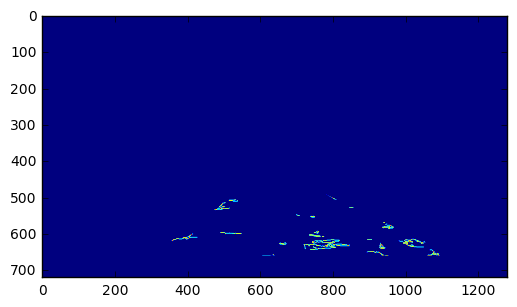

In [873]:
#pick area of interest
x_center = image.shape[1] / 2
top_left_v = (x_center-50,450)
low_left_v = (200,image.shape[0]-60)
top_right_v = (x_center+50,450)
low_right_v = (image.shape[1] - 150,image.shape[0]-60)
vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
image_mask = region_of_interest(image_gauss,vertices)
plt.imshow(image_mask)

value of: rt_lines_pos
[(792, 500), (797, 503), (784, 495)]
value of: lf_lines_pos
[(521, 507), (533, 506), (528, 506)]


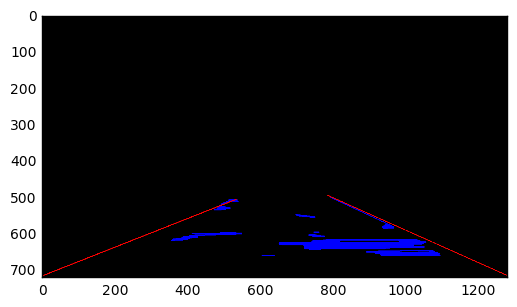

In [887]:
#determine hough lines
lines_hough = hough_lines(image_mask,0.5, np.pi/180, 10, 14, 150)
plt.imshow(lines_hough)

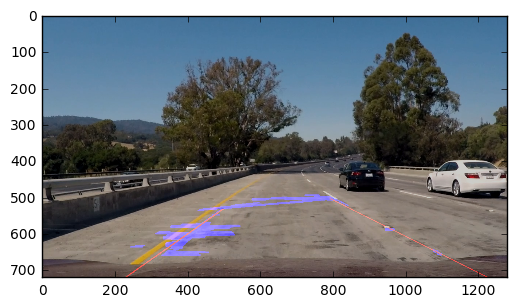

In [875]:
#Add weighed lines onto initial image
image_final = weighted_img(lines_hough,image)
plt.imshow(image_final)

In [718]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [888]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    image_grayed = grayscale(image)
    #image_canny = canny(image_grayed,220,255)
    canny_threshold = canny_auto_threshold(image_grayed)
    image_canny = canny(image_grayed,canny_threshold[0],canny_threshold[1])
    print(canny_threshold)

    kernel_size = 5
    image_gauss = gaussian_blur(image_canny,kernel_size)
    x_center = image.shape[1] / 2
    top_left_v = (x_center-50,450)
    low_left_v = (200,image.shape[0]-60)
    top_right_v = (x_center+50,450)
    low_right_v = (image.shape[1] - 150,image.shape[0]-60)
    vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
    image_mask = region_of_interest(image_gauss,vertices)
    lines_hough = hough_lines(image_mask,0.5, np.pi/180, 10, 14, 150)
    image_final = weighted_img(lines_hough,image)
    plt.imshow(image_final)
        
    return image_final

(43, 184)
value of: rt_lines_pos
[(776, 491), (812, 518), (755, 483), (764, 490), (768, 487), (779, 492), (752, 480), (760, 487), (760, 483), (969, 619), (812, 520), (752, 481), (916, 575), (755, 481), (914, 584), (969, 621), (988, 618), (821, 514), (816, 514), (969, 620), (970, 621), (911, 582), (812, 519), (823, 514), (820, 514)]
value of: lf_lines_pos
[(605, 452), (573, 471), (617, 450), (596, 457), (614, 450), (599, 451), (612, 450), (609, 450), (619, 450), (599, 452), (611, 450), (610, 450), (598, 450), (621, 450), (591, 461), (626, 450), (622, 450), (598, 453), (616, 450), (625, 450), (627, 450), (624, 450), (598, 456), (436, 592), (355, 585), (551, 489), (352, 585), (356, 587), (616, 454), (437, 593), (597, 450), (599, 450), (437, 592)]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4









  0%|          | 0/96 [00:00<?, ?it/s]






  1%|          | 1/96 [00:00<00:10,  9.46it/s]

(43, 184)
value of: rt_lines_pos
[(776, 491), (812, 518), (755, 483), (764, 490), (768, 487), (779, 492), (752, 480), (760, 487), (760, 483), (969, 619), (812, 520), (752, 481), (916, 575), (755, 481), (914, 584), (969, 621), (988, 618), (821, 514), (816, 514), (969, 620), (970, 621), (911, 582), (812, 519), (823, 514), (820, 514)]
value of: lf_lines_pos
[(605, 452), (573, 471), (617, 450), (596, 457), (614, 450), (599, 451), (612, 450), (609, 450), (619, 450), (599, 452), (611, 450), (610, 450), (598, 450), (621, 450), (591, 461), (626, 450), (622, 450), (598, 453), (616, 450), (625, 450), (627, 450), (624, 450), (598, 456), (436, 592), (355, 585), (551, 489), (352, 585), (356, 587), (616, 454), (437, 593), (597, 450), (599, 450), (437, 592)]
(43, 183)









  2%|▏         | 2/96 [00:00<00:10,  9.22it/s]

value of: rt_lines_pos
[(757, 484), (828, 530), (838, 524), (966, 615), (958, 600), (757, 483), (839, 524), (828, 528), (757, 482), (843, 523), (844, 524), (840, 523), (839, 523), (828, 529), (842, 523), (996, 633), (996, 622), (758, 482), (841, 523), (995, 620), (778, 492), (828, 525), (965, 608), (764, 489), (843, 524)]
value of: lf_lines_pos
[(614, 450), (611, 450), (597, 456), (615, 450), (608, 450), (613, 450), (609, 450), (616, 450), (619, 450), (574, 470), (610, 451), (556, 481), (608, 451), (624, 450), (622, 450), (588, 464), (337, 595), (424, 597), (340, 595), (620, 450), (424, 599), (335, 595), (575, 474), (333, 595), (341, 595), (617, 450), (623, 450), (342, 595), (552, 490), (422, 603), (424, 596), (422, 598), (424, 598), (499, 517), (304, 616), (334, 595), (525, 509), (303, 618), (619, 451), (616, 451)]


(44, 183)
value of: rt_lines_pos
[(1028, 637), (1033, 638), (865, 536), (763, 487), (1025, 637), (1035, 638), (1027, 637), (791, 498), (763, 488), (763, 486), (763, 485), (1015, 640), (1014, 638), (1016, 636), (1014, 641), (764, 489), (784, 503), (861, 536), (771, 494), (779, 492), (1019, 636), (1013, 644), (1022, 637), (772, 489), (1039, 639), (1014, 642), (851, 536)]
value of: lf_lines_pos
[(593, 452), (538, 486), (573, 471), (593, 454), (593, 451), (592, 450), (593, 453), (578, 468), (599, 455), (592, 459), (591, 450), (609, 450), (537, 486), (588, 451), (600, 455), (514, 509), (610, 450), (538, 488), (608, 450), (538, 485), (613, 450), (592, 454), (376, 596), (611, 451), (592, 451), (614, 450), (611, 450), (618, 450), (379, 597), (537, 485), (622, 450), (619, 450), (593, 450), (584, 464), (587, 453), (523, 503), (594, 458), (617, 450), (537, 484), (623, 450), (621, 450), (536, 485), (612, 450)]
(33, 183)
value of: rt_lines_pos
[(769, 491), (769, 492), (769, 488), (772, 489), (779, 








  4%|▍         | 4/96 [00:00<00:09,  9.61it/s]






  5%|▌         | 5/96 [00:00<00:10,  9.08it/s]

(36, 183)
value of: rt_lines_pos
[(777, 496), (779, 492), (777, 497), (751, 479), (789, 497), (795, 500), (800, 502), (808, 506), (777, 498), (778, 497), (792, 508), (777, 495), (777, 493), (922, 570), (806, 505), (792, 505), (777, 492)]
value of: lf_lines_pos
[(622, 450), (606, 452), (584, 465), (596, 458), (610, 450), (592, 460), (543, 491), (627, 450), (580, 468), (528, 499), (620, 450), (623, 450), (559, 481), (626, 450), (529, 499), (625, 450), (558, 483), (563, 499), (545, 490), (630, 450), (619, 450), (628, 450), (563, 500), (598, 457), (629, 450), (617, 450), (439, 588), (576, 471), (439, 589), (587, 452), (554, 484), (530, 499), (587, 465), (611, 450), (587, 453), (612, 450)]
(43, 186)
value of: rt_lines_pos
[(756, 482), (756, 481), (786, 498), (756, 483), (787, 498), (800, 502), (804, 516), (785, 499), (785, 503), (810, 520), (788, 497), (757, 483), (790, 500), (816, 510), (821, 527), (793, 499), (786, 499), (802, 506), (839, 522), (823, 513)]
value of: lf_lines_pos
[(615, 45








  7%|▋         | 7/96 [00:00<00:09,  9.79it/s]






  9%|▉         | 9/96 [00:00<00:08, 10.57it/s]

value of: rt_lines_pos
[(796, 503), (760, 484), (799, 503), (761, 485), (801, 503), (803, 514), (760, 483), (797, 504), (796, 508), (761, 486), (798, 503), (1015, 627), (796, 509), (810, 507), (804, 505), (1013, 627), (822, 513), (980, 622), (991, 629), (1014, 627), (823, 513), (824, 528), (858, 532), (1011, 627)]
value of: lf_lines_pos
[(610, 450), (612, 450), (615, 450), (621, 450), (620, 450), (618, 450), (599, 456), (614, 451), (579, 468), (624, 450), (616, 450), (626, 450), (533, 498), (548, 509), (548, 510), (622, 450), (443, 588), (613, 450), (629, 450), (628, 450), (587, 463), (625, 450), (443, 590), (630, 450), (617, 450), (580, 455), (548, 511), (440, 593), (587, 469), (331, 595), (548, 513), (611, 451), (580, 458), (580, 456), (580, 459), (548, 512), (337, 595), (547, 497), (442, 589), (604, 453)]
(48, 183)
value of: rt_lines_pos
[(809, 510), (813, 510), (769, 489), (814, 510), (808, 510), (808, 517), (769, 490), (818, 511), (808, 516), (820, 514), (811, 510), (815, 510), (8








 11%|█▏        | 11/96 [00:01<00:07, 10.66it/s]

(51, 185)
value of: rt_lines_pos
[(745, 476), (839, 532), (839, 530), (756, 481), (839, 531), (755, 481), (784, 501), (849, 530), (751, 479), (851, 530), (784, 497), (841, 530), (843, 530), (784, 496), (752, 481), (840, 537), (869, 547), (845, 536), (847, 530)]
value of: lf_lines_pos
[(623, 450), (620, 450), (614, 450), (616, 450), (617, 450), (621, 450), (611, 450), (625, 450), (612, 450), (601, 455), (610, 450), (626, 450), (629, 450), (613, 456), (512, 538), (627, 450), (618, 450), (580, 468), (630, 450), (593, 470), (512, 540), (448, 536), (569, 463), (569, 461), (622, 451), (512, 539), (631, 450), (603, 454), (611, 459), (448, 538)]
(45, 183)
value of: rt_lines_pos
[(874, 544), (791, 502), (881, 547), (797, 501), (793, 501), (882, 548), (758, 482), (791, 501), (898, 558), (753, 480), (875, 544), (745, 476), (795, 501), (910, 564), (867, 544), (914, 568), (796, 501), (944, 585), (744, 476), (802, 503), (745, 477), (871, 544), (943, 586), (766, 486), (756, 481), (913, 565), (950, 58








 14%|█▎        | 13/96 [00:01<00:08, 10.32it/s]

value of: rt_lines_pos
[(811, 508), (808, 507), (901, 575), (903, 560), (804, 507), (899, 559), (807, 507), (812, 509), (916, 586), (753, 480), (756, 481), (816, 510), (911, 564), (890, 559), (762, 484), (915, 565), (898, 559), (894, 560), (748, 478), (895, 559), (1012, 636), (756, 484), (806, 507)]
value of: lf_lines_pos
[(612, 450), (589, 462), (596, 458), (568, 475), (615, 450), (608, 451), (580, 468), (614, 450), (611, 450), (488, 530), (566, 475), (565, 475), (616, 450), (624, 450), (604, 453), (625, 450), (446, 559), (622, 450), (572, 473), (621, 450), (411, 582), (608, 455), (597, 464), (391, 568), (560, 483), (609, 451), (620, 450), (627, 450), (466, 545), (446, 599), (617, 450), (392, 568), (393, 569), (393, 570), (421, 576), (393, 568), (629, 450), (472, 570), (618, 450), (471, 570), (447, 599), (387, 568), (388, 568), (389, 568), (391, 570), (410, 582), (473, 574), (631, 450), (447, 600), (568, 476)]
(42, 186)
value of: rt_lines_pos
[(752, 480), (815, 522), (752, 481), (815,








 16%|█▌        | 15/96 [00:01<00:07, 10.65it/s]

(49, 184)
value of: rt_lines_pos
[(764, 485), (763, 486), (1019, 639), (776, 491), (1018, 627), (799, 502), (763, 485), (763, 487), (781, 493), (769, 492), (863, 537), (1019, 638), (1019, 640), (862, 537), (1022, 626), (764, 486), (1021, 627), (1019, 641), (1019, 628), (1031, 650), (1019, 637), (865, 537), (795, 500), (763, 488)]
value of: lf_lines_pos
[(604, 452), (611, 450), (609, 450), (615, 450), (593, 458), (606, 451), (613, 450), (575, 469), (593, 460), (616, 450), (436, 597), (549, 486), (598, 455), (621, 450), (618, 450), (437, 599), (625, 450), (608, 450), (435, 596), (437, 598), (576, 472), (623, 450), (627, 450), (614, 451), (617, 450), (612, 450), (431, 601), (556, 487), (576, 489), (605, 454), (437, 601), (597, 456), (622, 450), (583, 464), (433, 596), (404, 622), (620, 450), (592, 464)]
(51, 188)
value of: rt_lines_pos
[(769, 490), (770, 488), (779, 492), (769, 488), (784, 502), (769, 489), (770, 491), (802, 503), (745, 476), (795, 509), (806, 505), (769, 492), (780, 493)








 18%|█▊        | 17/96 [00:01<00:08,  9.58it/s]

(46, 182)
value of: rt_lines_pos
[(776, 492), (776, 493), (779, 492), (776, 491), (791, 498), (800, 502), (776, 497), (776, 496), (785, 496), (778, 494), (801, 503), (803, 514), (812, 508), (777, 497)]
value of: lf_lines_pos
[(599, 454), (588, 460), (607, 450), (612, 450), (603, 452), (614, 450), (608, 450), (610, 450), (595, 456), (578, 469), (613, 450), (615, 450), (571, 471), (533, 496), (612, 452), (609, 450), (590, 459), (617, 450), (621, 450), (567, 474), (583, 474), (577, 467), (551, 489), (620, 450), (538, 493), (605, 451), (618, 450)]
(50, 188)
value of: rt_lines_pos
[(787, 497), (754, 483), (785, 503), (789, 497), (786, 497), (802, 503), (785, 497), (785, 502), (792, 508), (786, 502), (816, 510), (809, 519), (754, 481), (838, 522), (803, 515), (840, 523)]
value of: lf_lines_pos
[(614, 450), (615, 450), (612, 450), (610, 450), (630, 450), (555, 500), (629, 450), (599, 455), (627, 450), (607, 451), (555, 502), (593, 458), (616, 450), (555, 505), (555, 503), (607, 455), (609, 45








 20%|█▉        | 19/96 [00:01<00:07, 10.29it/s]






 22%|██▏       | 21/96 [00:01<00:06, 11.02it/s]

value of: rt_lines_pos
[(741, 474), (799, 504), (794, 510), (759, 485), (812, 508), (759, 483), (759, 487), (808, 519), (802, 504), (760, 484), (801, 504), (795, 504), (766, 486), (977, 625), (809, 512), (759, 486), (977, 623), (794, 509)]
value of: lf_lines_pos
[(601, 454), (611, 450), (595, 457), (613, 450), (570, 472), (581, 465), (588, 461), (609, 450), (605, 452), (614, 450), (617, 450), (612, 450), (626, 450), (610, 450), (546, 488), (624, 450), (592, 464), (375, 633), (584, 471), (615, 450), (620, 450), (623, 451), (506, 515), (616, 451), (547, 511), (599, 459), (627, 450), (619, 450), (547, 512), (547, 510), (621, 450), (551, 496)]
(49, 183)
value of: rt_lines_pos
[(807, 519), (766, 487), (741, 474), (806, 515), (768, 487), (767, 488), (821, 528), (820, 527), (744, 477), (839, 540), (815, 512), (766, 486), (806, 517), (838, 537), (836, 537), (816, 512), (743, 476)]
value of: lf_lines_pos
[(609, 451), (565, 476), (611, 450), (598, 456), (605, 453), (448, 556), (614, 450), (587, 

(46, 184)
value of: rt_lines_pos
[(839, 539), (848, 544), (845, 531), (781, 496), (741, 474), (752, 482), (783, 495), (859, 551), (838, 535), (856, 549), (785, 495), (781, 499), (861, 552), (871, 558), (781, 502), (838, 538), (838, 536), (782, 495), (789, 497), (886, 566)]
value of: lf_lines_pos
[(620, 450), (615, 450), (612, 450), (616, 450), (613, 450), (626, 450), (619, 450), (610, 450), (618, 450), (506, 537), (623, 450), (621, 450), (507, 538), (606, 452), (508, 538), (603, 453), (440, 538), (509, 539), (625, 450), (595, 457), (603, 455), (436, 537), (590, 463), (622, 451), (595, 460), (509, 540), (509, 541), (504, 537), (507, 537), (438, 537), (628, 450), (509, 538), (440, 541), (509, 542), (502, 538), (558, 484), (440, 537)]
(45, 187)
value of: rt_lines_pos
[(802, 503), (751, 479), (865, 545), (796, 502), (797, 502), (799, 502), (882, 550), (800, 502), (862, 545), (744, 476), (803, 506), (745, 476), (864, 545), (868, 546), (794, 502), (913, 568), (747, 479), (792, 502), (870, 54

ValueError: cannot convert float NaN to integer

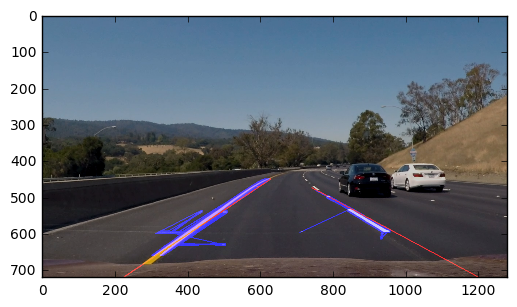

In [889]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4').set_duration(3.8,change_end=True)
#clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)